In [1]:
using Plots, FFTW
#cd("/home/user/Desktop/Mycop")

In [ ]:
using Distributed # многопоточные вычисления
addprocs(7)
@everywhere using FFTW
FFTW.set_num_threads(8)
nprocs()

## Solitons galaxy collisions

https://github.com/auckland-cosmo/PyUltraLight

In [9]:
include("Soliton_profile.jl")

initsoliton! (generic function with 1 method)

In [10]:
@time rvec, solprof, potprof, betac, soliton_mass = soliton_profile_maker();

M_core = 0.9177150298338503
Full width at half maximum density is 1.3801600199989883
Beta is 2.453887276090739
mass is 3.8827652756438376
Radius at 90 mass is 1.7604700100030657
  1.222649 seconds (95.74 k allocations: 54.256 MiB, 2.83% gc time, 3.25% compilation time)


In [ ]:
# 708.7975409030914 seconds - убогий питон код
# 355.097274 seconds (5.76 G allocations: 86.249 GiB... - отвратная версия на Джулия
# 290.755335 seconds (5.76 G allocations: 86.249 GiB... - без пушей в k1...k4
# 2.668681 seconds (421.87 k allocations: 71.290 MiB... - типобезопасное завернутое в функцию

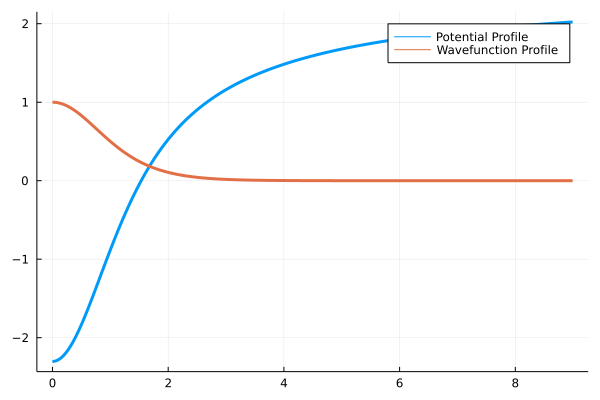

In [11]:
plot( rvec[1:1000:end], potprof[1:1000:end], label="Potential Profile", line = 3)
plot!(rvec[1:1000:end], solprof[1:1000:end], label="Wavefunction Profile", line = 3)

In [17]:
# schrodinger poisson equation - split step fourier transform
function spe_ssft_3d!(Nt, dt, ψ::Array{ComplexF64, 3}, ΔL)

    Nx = size(ψ, 1)
    K = fftfreq(Nx) * (2π*Nx/ΔL)
    k² = [ x^2+y^2+z^2 for x in K, y in K, z in K]
    eᵏ = exp.(-im*0.5*dt*k²)
    k² .= -4π ./ k²
    
    ρ = abs2.(ψ)# .- sum(abs2.(ψ))/length(ψ)
    Φ = fft(ρ)
    Φ .*= k²
    Φ[1] = 0.0
    ifft!(Φ)
    Φ .= real.(Φ)

    ψ .*= exp.(im*0.5*dt*Φ)
    
    for i in 1:Nt
        ψ .*= exp.(-im*dt*Φ)
        fft!(ψ)
        ψ .*= eᵏ
        ifft!(ψ)
        
        ρ .= abs2.(ψ)# .- sum(abs2.(ψ))/length(ψ) # average density
        Φ .= fft(ρ)
        Φ .*= k²
        Φ[1] = 0.0
        ifft!(Φ)
        Φ .= real.(Φ)
    end
    
    ψ .*= exp.(-im*0.5*dt*Φ)
end;

In [29]:
axion_mass = 1e-22 #*1.783e-36 #kg
# Set box size and resolution
gridlength = 16 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
resol= 256 # It is recommended to check the upper bound on soliton mass for a given box size 
#and resolution
#duration = 0.2 # 1 code unit is ~70 Gyr (independent of axion mass assumption)
t0 = 0.0 # Should be given in the same units as duration. 
#cmass = 0. # Give this parameter in the same units as the soliton mass unit.
#i.e. units must match with s_mass_unit
m = 8 #1 code unit is ~2.3e6 M_sol (1e-22/m_a)^1.5
r = 2 #1 code unit is ~38 kpc x (1e-22/m_a)^0.5

#Soliton parameters are mass, position, velocity and phase (radians)
soliton1 = [2m, [r,0,0], [-2.0,1.0,0.1], 0]
soliton2 = [m, [-r,0,0], [4,0,0], 0]

solitons = [soliton1,soliton2] 
Vcell = (gridlength / float(resol)) ^ 3
gridvec = range(-0.5gridlength + gridlength/float(2resol), 
    stop = 0.5gridlength - gridlength/float(2resol), length = resol);

In [30]:
psi = zeros(ComplexF64, resol, resol, resol)
sol_i = zeros(ComplexF64, resol, resol, resol);

for s in solitons
    mass = s[1]
    positionc = s[2]
    velocity = s[3]
    alphac = (mass / soliton_mass) ^ 2
    phase = s[4]
    initsoliton!(sol_i, gridvec, positionc, alphac, solprof, 1e-5)
    ####### Impart velocity to solitons in Galilean invariant way
    velx = velocity[1]
    vely = velocity[2]
    velz = velocity[3]
    sol_i .*= exp.(im*(alphac*betac*t0 .+
            [velx*x + vely*y + velz*z for x in gridvec, y in gridvec, z in gridvec] .-
            0.5*(velx*velx+vely*vely+velz*velz)*t0 .+ phase))
    psi += sol_i
end
psi|>sum

-8207.240590027688 + 4715.1924706346745im

In [36]:
psi1 = copy(psi);
@time spe_ssft_3d!(2^2, 5e-3, psi1, gridlength);

  7.561455 seconds (3.65 k allocations: 4.750 GiB, 7.23% gc time, 0.05% compilation time)


In [16]:
abs2.(psi1)|>maximum

76.58460996138503

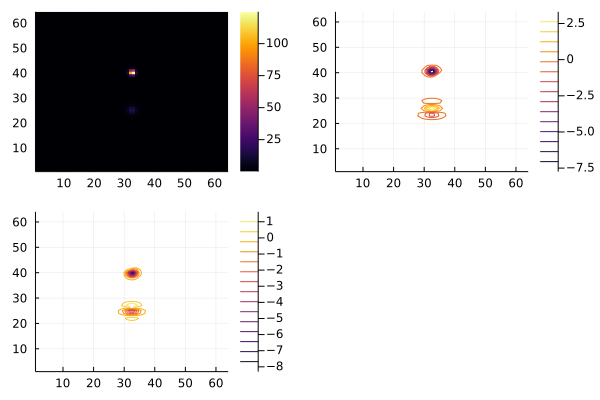

In [18]:
p1 = heatmap( abs2.(psi1[:,:,32]) )
p2 = contour( real.( psi1[:,:,32] ) )
p3 = contour( imag.( psi1[:,:,32] ) )
plot(p1, p2, p3)

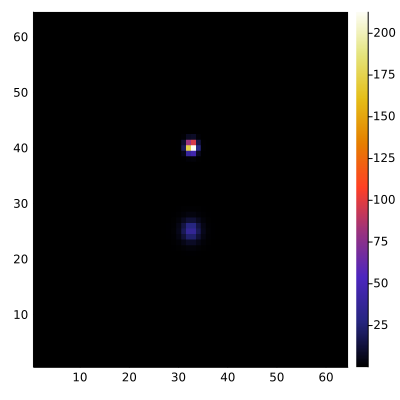

In [19]:
Ws = collect( range(0.5, stop=1, length = size(psi1,3)) );
#Ws = range(0, stop=1, length = size(psi1,3)).^2;
Pr = zeros(size(psi1)[1:2])
for i in 1:size(psi1,3)
    Pr += abs2.(psi1[:,:,i])*Ws[i]
end
heatmap(Pr, c = :CMRmap, size = (400,400) ) # cyclic_grey_15_85_c0_n256 # CMRmap

In [ ]:
psi1 = copy(psi)

@time anim = @animate for i in 1:100
    
    spe_ssft_3d!(2^7, 1e-4, psi1, gridlength);
    absi = abs2.(psi1[:,:,32])
    absi /= maximum(absi)
    heatmap(gridvec, gridvec, absi, colorbar = true ) # , size = (400,400)
end
gif(anim, "solts64.gif", fps = 5)

In [37]:
using HDF5 # большие расчеты собираем в файлы

In [38]:
fname = "galmerge3"
fid = h5open(fname, "w");

In [41]:
psi1 = copy(psi)

N = 2^9
fid["Num_steps"] = N

@time anim = @animate for i in 1:N
    
    spe_ssft_3d!(2^5, 1e-4, psi1, gridlength);
    fid["3d_qube_$i"] = psi1;
end
close(fid)

25721.206295 seconds (33.20 M allocations: 12.877 TiB, 2.77% gc time, 0.00% compilation time)


In [ ]:
fidd = h5open(fname, "r")

In [ ]:
# make animation from file
Ws = collect( range(0.5, stop=1, length = size(psi1,3)) );
N = read(fidd, "Num_steps")

anim = @animate for i in 1:N
    Psi = read(fidd, "3d_qube_$i");
    Pr = zeros(size(Psi)[1:2])
    for i in 1:size(Psi,3)
        Pr += abs2.(Psi[:,:,i])*Ws[i]
    end
    heatmap(gridvec, gridvec, Pr, colorbar = true, clims = (0,500),
        c = :CMRmap, size = (400,400), xlim = (-3,3), ylim = (-3,3) ) # , size = (400,400)
end

gif(anim, "solts3.gif", fps = 20)

In [43]:
close(fidd)

## Cosmic web

Для начальных условий нужна спектральная плотность матери (твоей, ха-ха)

In [6]:
function wave_number(s)
    N = s[1]
    I = CartesianIndices(s)
    [ [ i > N/2 ? i - N : i for i in getindex.(I, j).-1] for j in 1:length(s) ]
end

function Scale(K, res, sigma)
    """returns discrete scale space filter, take care with units: 
        [res] = Mpc / pixel, [k] = 1 / Mpc, [t] = Mpc**2"""
    eᵏ = [ exp.( sigma^2 / res^2 * (cos.(k*res) .- 1.0) ) for k in K ]
    return reduce(.*, eᵏ)
end

function garfield(shape, P, T = 1.0)
    wn = randn(shape)
    f  = real.( ifft(fft(wn) .* sqrt.(P)) )
    #f /= f.std()
    return real.( ifft(fft(f) .* T) )
end

# raise |k| to the <n>-th power safely
K_pow(K, n) = [ k<1e-12 ? 0.0 : k^n for k in K ] 
Power_law(K, n) = K_pow( sum( k-> k.^2, K ), n/2 )
Cutoff(K, k_max) = [ k <= k_max^2 ? 1.0 : 0.0 for k in sum( k-> k.^2, K ) ]
Potential(K) = -K_pow( sum( k-> k.^2, K ), -1.0 );

+ https://en.wikipedia.org/wiki/Matter_power_spectrum
+ https://www.uio.no/studier/emner/matnat/astro/AST4320/h12/undervisningsmateriale/transferproblem.pdf
+ https://www.uio.no/studier/emner/matnat/astro/AST4320/h12/undervisningsmateriale/xh03.pdf
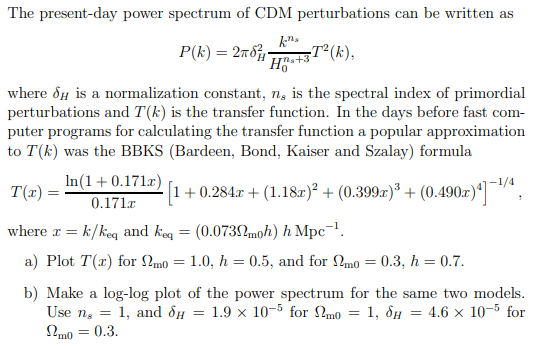

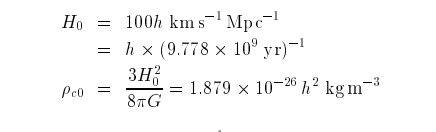

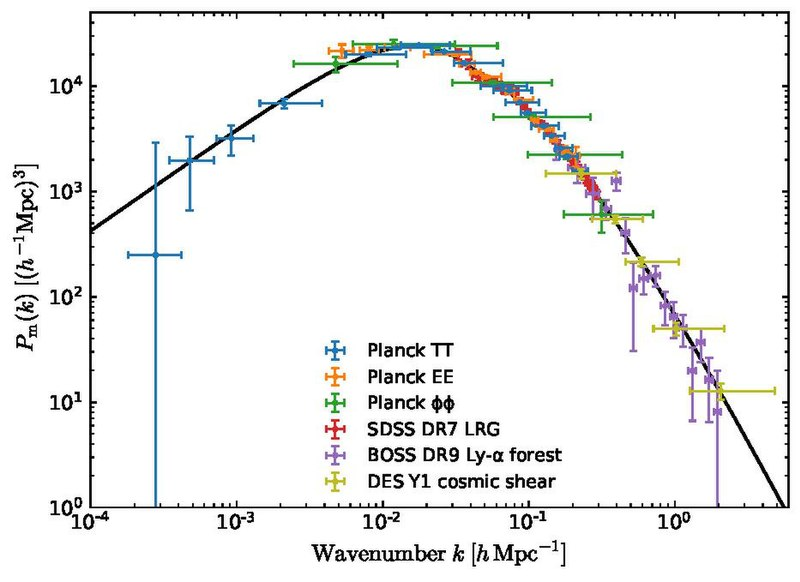

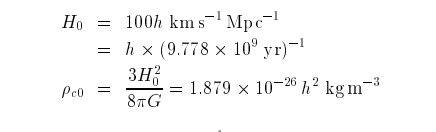

In [7]:
P(k,n) = 2π*A^2 * k^n * Tcdm(k/keq)^2 / H₀^(n+3)
Tcdm(q) = log(1+0.171q) / ( 0.171q*(1 + 0.284q + (1.18q)^2 + (0.399q)^3 + (0.49q)^4 )^0.25 );

In [ ]:
h = 0.5
H₀ = h / 9.778e9
Ω₀ = 1.0
A = 1.9e-5
keq = 0.073Ω₀*h;

In [8]:
h = 0.7
H₀ = h / 9.778e9
Ω₀ = 0.3
A = 4.6e-5
keq = 0.073Ω₀*h;

In [ ]:
X = [ 0.001:0.001:2; ]
Y2 = P.(X,1)
Y2 ./= minimum(Y2)

Y0 = X.^1
Y0 .+= Y2[1]

Y1 = X.^-2
Y1 ./= minimum(Y1)

plot( X, Y0 )
plot!( X, Y1 )
plot!( X, Y2, xaxis = :log, yaxis = :log )

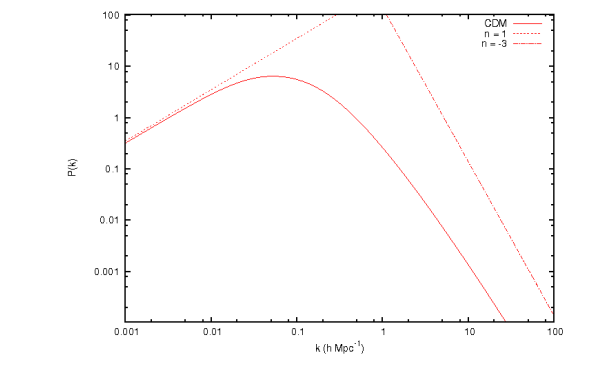

In [9]:
P(K,n) = 2π*A^2 * K_pow(K,n) .* Tcdm(K/keq).^2 / H₀^(n+3)
Pbbks(K, n) = P( sum( k-> abs.(k), K ), n )
Tcdm(q) = log.(1.0.+0.171q) .* 
K_pow( 0.171q.*K_pow(1.0 .+ 0.284q + K_pow(1.18q,2) + K_pow(0.399q,3) + K_pow(0.49q,4), 0.25 ), -1 );

In [10]:
N = 256
L = 64π
#A = 40
res = L/N
shape = (N,N,N)
K = wave_number(shape) * 2*pi / L;
k_max = N*pi/L
k_min = 2*pi/L;

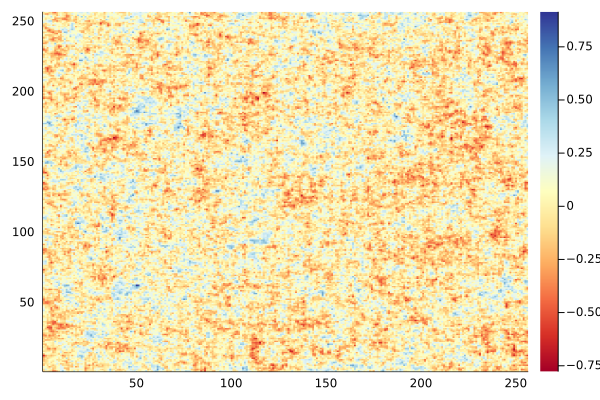

In [11]:
#rho1 = garfield(shape, Power_law(K,-2));
rho2 = garfield(shape, Pbbks(K,1));
#rho1 ./= abs( maximum(abs.(rho1)) )
rho2 ./= abs( maximum(abs.(rho2)) )
#p1 = heatmap( rho1[:,:,32], c = :RdYlBu_11 )
p2 = heatmap( rho2[:,:,32], c = :RdYlBu_11 )
#plot(p1, p2)

In [12]:
#psi1 = 0.001randn(ComplexF64, 64,64,64) .+ 1.0;
#reals = randn(128,128,128)
#imags = sqrt.( abs.(rho1) - reals.^2 )
#psi1 = sqrt.(rho1.-minimum(rho1)) + im*zeros(size(rho1));
psi2 = sqrt.(rho2.-minimum(rho2)) + im*zeros(size(rho2));

In [1]:
memr3d(Nx=100) = "Need for $(16*( Nx+ 6*Nx^3 )/(2^20)) mb";

In [2]:
memr3d(512)

"Need for 12288.0078125 mb"

In [22]:
@time spe_ssft_3d!(2^9, 1e-4, psi2, 8π); # 2^8 * 2^5

  6.072950 seconds (61.52 k allocations: 4.972 GiB, 0.90% gc time)


In [ ]:
#p1 = heatmap( abs2.(psi1[:,:,32]) ) # , c = :RdYlBu_11
p2 = heatmap( abs2.(psi2[:,:,32]) )
#plot(p1, p2)

In [ ]:
Ws = collect( range(0.5, stop=1, length = size(psi2,3)) );
#Ws = range(0, stop=1, length = size(psi1,3)).^2;
Pr = zeros(size(psi1)[1:2])
for i in 1:size(psi1,3)
    Pr += abs2.(psi1[:,:,i])*Ws[i]
end
heatmap(Pr, c = :CMRmap, size = (400,400) ) # cyclic_grey_15_85_c0_n256 # CMRmap

In [21]:
using HDF5

In [22]:
fname = "densdataz_256_64pi"

fid = h5open(fname, "w");

In [23]:
psi2 = sqrt.(rho2.-minimum(rho2)) + im*zeros(size(rho2));

N = 128
fid["Num_steps"] = N
@time for i in 1:N
    
    spe_ssft_3d!(2^7, 1e-4, psi2, 8π)
    fid["3d_qube_$i"] = psi2;
end
close(fid)

20803.092690 seconds (2.30 M allocations: 12.219 TiB, 2.92% gc time, 0.00% compilation time)


In [ ]:
fidd = h5open("densdataz_256_64", "r")

In [25]:
Ws = collect( range(0.5, stop=1, length = size(psi2,3)) ); # веса для слоев в кубике

In [ ]:
N = read(fidd, "Num_steps")

anim = @animate for i in 1:N
    Psi = read(fidd, "3d_qube_$i");
    Pr = zeros(size(Psi)[1:2])
    for i in 1:size(Psi,3)
        Pr += abs2.(Psi[:,:,i])*Ws[i]
    end
    heatmap(log.(Pr), c = :hot, xticks = false, yticks = false, colorbar = false, 
        clims = (5,9), title = i ) 
        #, size = (400,400) )
end

gif(anim, "evolut256_2pi.gif", fps = 2)

In [ ]:
N = read(fidd, "Num_steps")

anim = @animate for i in 1:N
    Psi = read(fidd, "3d_qube_$i");
    Pr = zeros(size(Psi)[1:2])
    for i in 1:size(Psi,3)
        Pr += abs2.(Psi[:,:,i])*Ws[i]
    end
    heatmap(Pr, c = :CMRmap, xticks = false, yticks = false, colorbar = true, size = (400,400), 
        clims = (0,360) )
end

gif(anim, "evolut_256.gif", fps = 5)